In [104]:
from torchsummary                 import summary
from tqdm                         import tqdm
from src.data.to_tensor           import ToTensor
from src.data.mrw_dataset         import MRWDataset
from src.data.create_data_loaders import create_data_loaders
from src.nn.archs                 import CNN_ALL, CNN_ALL_VDCNNFRW_M18, Wav2Vec2ALL
from src.nn.results.utils         import (get_all_predictions, analyse_predictions, 
                                            plot_distributions, plot_losses, get_MSEs, plot_correlation)

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.num_ctes  as nctes
import src.ctes.str_ctes  as sctes
import src.nn.path_ctes as pctes

# Model choice

In [105]:
builder   = CNN_ALL_VDCNNFRW_M18  
timestamp = "2024_02_08__09_32_10"
version   = "best"
data_path = pctes.DATAPATH 

In [106]:
arch_name = builder.__name__
hyperparams_path = f"../../../data/models/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/models/model_{arch_name}_{timestamp}_{version}.pt"
losses_path = f"../../../data/models/losses_{arch_name}_{timestamp}.npz"
losses_img_path = f"../../../data/models/losses_{arch_name}_{timestamp}.png"

# Hyperparameters

In [107]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../../data/models/hyperparams_CNN_ALL_VDCNNFRW_M18_2024_02_08__09_32_10.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [108]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

if sctes.MODEL_NAME in hyperparams :
    print(f"Model name       = {hyperparams[sctes.MODEL_NAME]}")
print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
# print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")
if sctes.DROPOUT_PROBS in hyperparams:
    print(f"Dropout probas    = {hyperparams[sctes.DROPOUT_PROBS].tolist()}")
print(f"Labels           = {builder.LABELS}")

Model name       = Top-Down v2
Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 250
Loss             = MSELoss()
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0
)
Seed             = 42.0
Dropout probas    = []
Labels           = ['c1', 'c2', 'L', 'EPSILON']


In [109]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Model Summary

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [111]:
sample_size = nctes.LEN_SAMPLE
model = builder(input_size=sample_size, dropout_probs=hyperparams[sctes.DROPOUT_PROBS])
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Sequential: 2-1                   [-1, 64, 8173]            --
|    |    └─Conv1d: 3-1                  [-1, 64, 8173]            5,120
|    |    └─BatchNorm1d: 3-2             [-1, 64, 8173]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8173]            --
|    └─MaxPool1d: 2-2                    [-1, 64, 2043]            --
|    └─Sequential: 2-3                   [-1, 64, 2041]            --
|    |    └─Conv1d: 3-4                  [-1, 64, 2041]            12,288
|    |    └─BatchNorm1d: 3-5             [-1, 64, 2041]            128
|    |    └─ReLU: 3-6                    [-1, 64, 2041]            --
|    └─Sequential: 2-4                   [-1, 64, 2039]            --
|    |    └─Conv1d: 3-7                  [-1, 64, 2039]            12,288
|    |    └─BatchNorm1d: 3-8             [-1, 64, 2039]            128
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Sequential: 2-1                   [-1, 64, 8173]            --
|    |    └─Conv1d: 3-1                  [-1, 64, 8173]            5,120
|    |    └─BatchNorm1d: 3-2             [-1, 64, 8173]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8173]            --
|    └─MaxPool1d: 2-2                    [-1, 64, 2043]            --
|    └─Sequential: 2-3                   [-1, 64, 2041]            --
|    |    └─Conv1d: 3-4                  [-1, 64, 2041]            12,288
|    |    └─BatchNorm1d: 3-5             [-1, 64, 2041]            128
|    |    └─ReLU: 3-6                    [-1, 64, 2041]            --
|    └─Sequential: 2-4                   [-1, 64, 2039]            --
|    |    └─Conv1d: 3-7                  [-1, 64, 2039]            12,288
|    |    └─BatchNorm1d: 3-8             [-1, 64, 2039]            128
|

In [112]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [113]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


# Data Load

In [114]:
transform = ToTensor()

data      = MRWDataset(data_path, transform, sample_size, builder.LABELS)

In [115]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

# Plot Losses

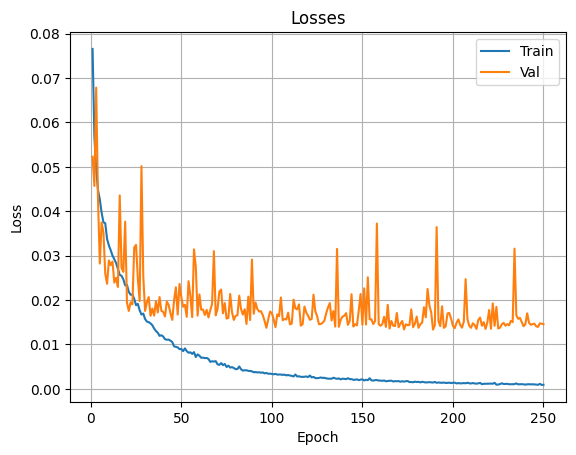

In [116]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

# General Performance

In [117]:
targets, preds, output_losses  = get_all_predictions(model, test_loader, device, criterion, builder.LABELS)

100%|██████████| 427/427 [00:05<00:00, 79.37it/s]


In [122]:
# analyse_predictions(targets, preds)

In [119]:
total_test_loss, mean_output_losses = get_MSEs(targets, preds, output_losses, builder.LABELS, device, criterion)
print("Total Test MSE = {:0.4f}".format(total_test_loss))
print("")
print("Test MSE for each output:")
for key, value in mean_output_losses.items():
    print(f"{key}: {value:.4f}")

Total Test MSE = 0.0139

Test MSE for each output:
c1: 0.0019
c2: 0.0162
L: 0.0292
EPSILON: 0.0084


# Predictions Distribution

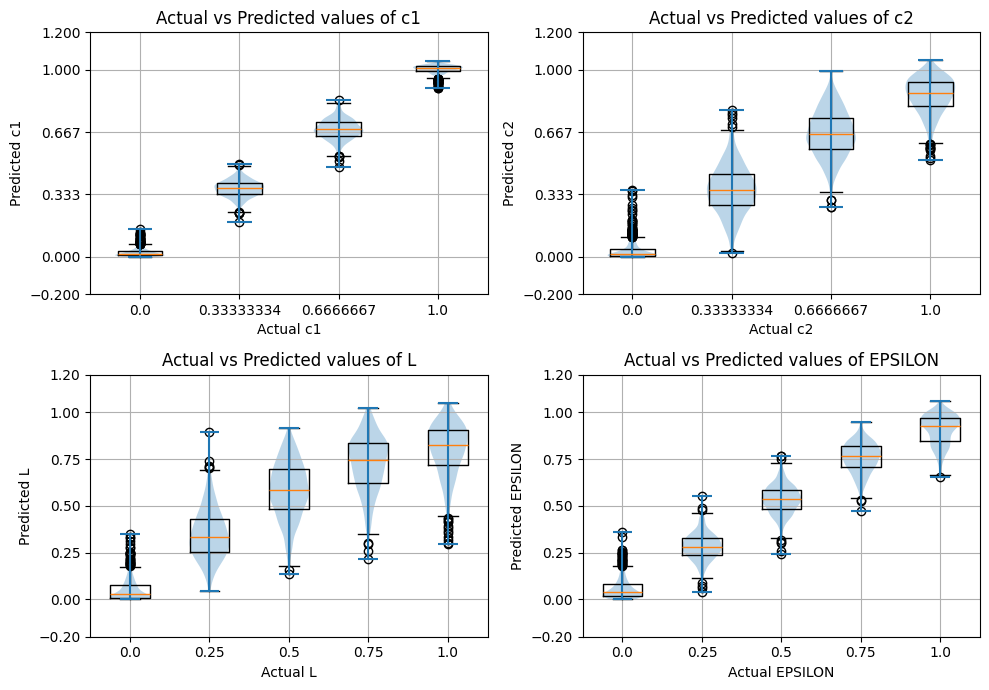

In [120]:
plot_distributions(targets, preds, builder.LABELS)

# Correlation Matrix

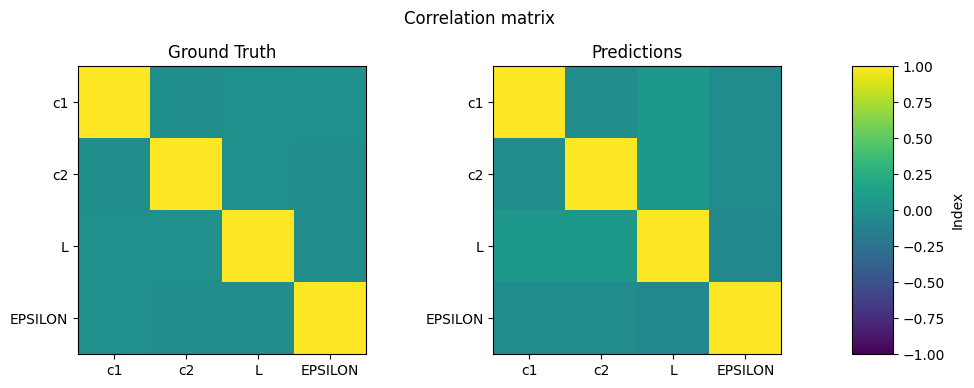

In [121]:
plot_correlation(targets, preds, builder.LABELS)